In [1]:
import logging
from argparse import ArgumentParser

import torch
import torch.nn.functional as F
import wandb
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm import trange

from experiments.data import INRDataset
from experiments.utils import (
    common_parser,
    count_parameters,
    get_device,
    set_logger,
    set_seed,
    str2bool,
)
from nn.models import DWSModelForClassification, MLPModelForClassification

from experiments.mnist.generate_data_splits import generate_splits
from experiments.mnist.compute_statistics import compute_stats


set_logger()

In [2]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.enabled = False

In [3]:
path = "DWSNets/dataset/mnist_splits.json" # data_path = 
statistics_path = "DWSNets/dataset/statistics.pth" # data_path = 
normalize = True
augmentation = True

batch_size = 32
num_workers = 4


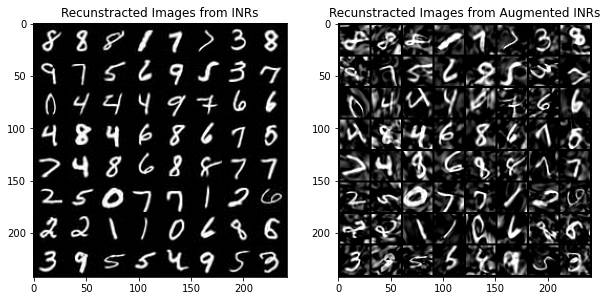

In [4]:
from torchvision.utils import save_image, make_grid
import torch

from experiments.data import INRImageDataset
from experiments.utils import set_seed
import matplotlib.pyplot as plt

# Create non-augmented INRImage Dataset
dataset = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=False,
    split="train",
)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

# Create augmented INRImage Dataset
dataset_aug = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=True,
    split="train",
)
loader_aug = torch.utils.data.DataLoader(dataset_aug, batch_size=64, shuffle=False)


batch = next(iter(loader))
batch_aug = next(iter(loader_aug))


fig, axs = plt.subplots(1, 2, figsize=(10,20)) 

axs[0].imshow(make_grid(batch.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[0].set_title('Recunstracted Images from INRs')

axs[1].imshow(make_grid(batch_aug.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[1].set_title('Recunstracted Images from Augmented INRs')
plt.show()


In [5]:
train_set = INRDataset(
        path=path,
        split="train",
        normalize=normalize,
        augmentation=augmentation,
        statistics_path=statistics_path,
    ) # create dataset for the training set (seen in training)

val_set = INRDataset(
    path=path,
    split="val",
    normalize=normalize,
    statistics_path=statistics_path,
) # create dataset for the validation set (seen in training)

test_set = INRDataset(
    path=path,
    split="test",
    normalize=normalize,
    statistics_path=statistics_path,
) # create dataset for the test set (not seen in training)


# Now make torch dataloaders for those datasets
train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

# Keeping track of stuff
logging.info(
    f"train size {len(train_set)}, "
    f"val size {len(val_set)}, "
    f"test size {len(test_set)}"
)

# Try running the DWSNet on augmented INRs like displayed and not the raw ones like it does stock

/home/biggs.s/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
2024-09-27 08:34:52,281 - root - INFO - train size 55000, val size 5000, test size 10000


In [6]:
from typing import Tuple
from nn.layers import BN, DownSampleDWSLayer, Dropout, DWSLayer, InvariantLayer, ReLU
from nn.layers.base import BaseLayer, GeneralSetLayer
from nn.models import DWSModel

import matplotlib.pyplot as plt
import random
import numpy as np

In [7]:
point = train_set.__getitem__(4)
weight_shapes = tuple(w.shape[:2] for w in point.weights)
bias_shapes = tuple(b.shape[:1] for b in point.biases)
print(weight_shapes,bias_shapes)
# print(point.weights,point.biases,point.label)

new_weight_shapes = (torch.Size([2, 8]), torch.Size([8, 8]), torch.Size([8, 1]))
new_bias_shapes = (torch.Size([8]), torch.Size([8]), torch.Size([1]))

(torch.Size([2, 32]), torch.Size([32, 32]), torch.Size([32, 1])) (torch.Size([32]), torch.Size([32]), torch.Size([1]))


In [8]:
from typing import Tuple
import torch
import torch.nn as nn
from nn.layers import BN, DWSLayer,InvariantLayer, Dropout, ReLU
from nn.layers.base import BaseLayer,GeneralSetLayer

class DWSEncoder(BaseLayer):
    def __init__(
       self,
        weight_shapes,
        bias_shapes,
        input_features,
        hidden_dims,
        downsample_dim,
        n_hidden=2,
        reduction="max",
        bias=True,
        n_fc_layers=1,
        num_heads=4,
        set_layer="sab",
        add_layer_skip=False,
        input_dim_downsample=None,
        dropout_rate=0.0,
        init_scale=1.,
        init_off_diag_scale_penalty=1.,
        bn=False,
        diagonal=False,
    ):
        super().__init__(
            in_features=input_features,
            out_features=hidden_dims,
            bias=bias,
            reduction=reduction,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
        )

        assert len(weight_shapes) > 2, "The implementation only supports networks with more than 2 layers."

        self.downsample_dim = downsample_dim
        self.bias = bias
        self.n_fc_layers = n_fc_layers
        self.num_heads = num_heads
        
        self.skip = self._get_mlp(
            in_features=input_features,
            out_features=input_features,
            bias=bias,
        )
        
        self.InitialLayer = DWSModel(
            weight_shapes= weight_shapes,
            bias_shapes= bias_shapes,
            input_features=input_features,
            hidden_dim=hidden_dims,
            n_hidden=n_hidden,
            reduction=reduction,
            bias=bias,
            output_features=input_features,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
            dropout_rate=dropout_rate,
            input_dim_downsample=input_dim_downsample,
            init_scale=init_scale,
            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
            bn=bn,
            add_skip=False,
            add_layer_skip=add_layer_skip,
            diagonal=diagonal,
        )
        
    def downsample_input_weights(self, inputs, downsample_dim):
        """Downsample the input weights to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first weight dimension [32,2,32,1] -> [32,2,8,1]
        inputs[0] = self._downsample_weight(inputs[0], dim=2, downsample_dim = downsample_dim)
        # Downsample second weight dimension [32,32,32,1] -> [32,8,8,1]
        inputs[1] = self._downsample_weight(inputs[1], dim=1, downsample_dim = downsample_dim)
        inputs[1] = self._downsample_weight(inputs[1], dim=2, downsample_dim = downsample_dim)

        # Downsample third weight dimension [32,32,1,1] -> [32,8,1,1]
        inputs[2] = self._downsample_weight(inputs[2], dim=1, downsample_dim = downsample_dim)

        return tuple(inputs)

    def downsample_input_biases(self, inputs, downsample_dim):
        """Downsample the input biases to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first bias dimension [32,32,1] -> [32,8,1]
        inputs[0] = self._downsample_bias(inputs[0], downsample_dim= downsample_dim)

        # Downsample second bias dimension [32,32,1] -> [32,8,1]
        inputs[1] = self._downsample_bias(inputs[1], downsample_dim = downsample_dim)

        return tuple(inputs)
    
    def batchNormLayer(self,weights, biases):
        weights = tuple(nn.BatchNorm2d(w.shape[1]).to(device)(w) for w in weights)
        biases = tuple(nn.BatchNorm1d(b.shape[1]).to(device)(b.squeeze(-1)).unsqueeze(-1) for b in biases)
        return weights, biases
    
    def forward(self, x: Tuple[Tuple[torch.tensor], Tuple[torch.tensor]]):
        """Forward pass through the encoder."""
        x = self.InitialLayer(x)
        weights = self.downsample_input_weights(x[0], self.downsample_dim)
        biases = self.downsample_input_biases(x[1], self.downsample_dim)
        weights, biases = self.batchNormLayer( weights, biases)
        out = (weights, biases)
        return out

    def _downsample_weight(self, weight, dim,downsample_dim):
        d0 = weight.shape[dim]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features= downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = weight.permute(0, 3, 1, 2) if dim == 2 else weight.permute(0, 3, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 3, 1) if dim == 2 else wi.permute(0, 3, 2, 1)

    def _downsample_bias(self, bias, downsample_dim):
        d0 = bias.shape[1]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features=downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = bias.permute(0, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 1)

In [28]:
# Our AutoEncoder using DWSModel
import numpy as np
class AssembleEncoderBlocks2(nn.Module):
    def __init__(self,
#             input_features,
#             weight_shapes,
#             bias_shapes,
            first_hidden_dim = 32,
            target_downsample_dim = 8,
            n_hidden = 1,
            reduction = "max",
            input_dim_downsample=None,
            bn = False,
    ):
        super().__init__()
        

        weight_shapes_list = []
        bias_shapes_list = []
        
        grade = int(first_hidden_dim/target_downsample_dim )
        assert grade > 0, "grade must be at least 1."
        for i in range( grade ):
            layer_weight_dim = (grade - i)*target_downsample_dim
            weight_shapes_list.append((torch.Size([2, layer_weight_dim]), 
                                       torch.Size([layer_weight_dim,layer_weight_dim]), 
                                       torch.Size([layer_weight_dim, 1])
                                      )
                                     )
        for j in range( grade ):
            layer_bias_dim = (grade - j)*target_downsample_dim
            bias_shapes_list.append((torch.Size([layer_bias_dim]),
                                     torch.Size([layer_bias_dim]),
                                     torch.Size([1])
                                    )
                                   )

            
        self.encoder_layers = nn.ModuleList()
        for k in range( grade ):
            self.encoder_layers.append(DWSEncoder(weight_shapes = weight_shapes_list[k],
                                                  bias_shapes = bias_shapes_list[k],
                                                  input_features = 1, 
                                                  hidden_dims = (grade - k)*target_downsample_dim, # use this to speed up shapes?
                                                  downsample_dim = max((grade - k-1), 1)*target_downsample_dim,
                                                  n_hidden = n_hidden,
                                                  reduction = reduction,
                                                  bn = False,
                                                 )
                                       )
            

        
        
        
    def forward(self, x: Tuple[Tuple[torch.tensor], Tuple[torch.tensor]]):
        i = 0
        for layer in self.encoder_layers:
            
#Useful shape printers to make sure that everything is lining up            
            print(f"Pass no: {i} (zero-indexed)")
            for j in range(len(x[0])):
                print(f"Weight Shapes: {x[0][j].shape}")
            for k in range(len(x[1])):
                print(f"Bias Shapes: {x[1][k].shape}")
                
            i = i+1
            x = layer(x)
            
        return x

In [29]:
w, b, l = next(iter(train_loader))
input = (w, b)
test2 = AssembleEncoderBlocks2().to(device)
test2(input)

Pass no: 0 (zero-indexed)
Weight Shapes: torch.Size([32, 2, 32, 1])
Weight Shapes: torch.Size([32, 32, 32, 1])
Weight Shapes: torch.Size([32, 32, 1, 1])
Bias Shapes: torch.Size([32, 32, 1])
Bias Shapes: torch.Size([32, 32, 1])
Bias Shapes: torch.Size([32, 1, 1])
Pass no: 1 (zero-indexed)
Weight Shapes: torch.Size([32, 2, 24, 1])
Weight Shapes: torch.Size([32, 24, 24, 1])
Weight Shapes: torch.Size([32, 24, 1, 1])
Bias Shapes: torch.Size([32, 24, 1])
Bias Shapes: torch.Size([32, 24, 1])
Bias Shapes: torch.Size([32, 1, 1])
Pass no: 2 (zero-indexed)
Weight Shapes: torch.Size([32, 2, 16, 1])
Weight Shapes: torch.Size([32, 16, 16, 1])
Weight Shapes: torch.Size([32, 16, 1, 1])
Bias Shapes: torch.Size([32, 16, 1])
Bias Shapes: torch.Size([32, 16, 1])
Bias Shapes: torch.Size([32, 1, 1])
Pass no: 3 (zero-indexed)
Weight Shapes: torch.Size([32, 2, 8, 1])
Weight Shapes: torch.Size([32, 8, 8, 1])
Weight Shapes: torch.Size([32, 8, 1, 1])
Bias Shapes: torch.Size([32, 8, 1])
Bias Shapes: torch.Size([3

((tensor([[[[-0.5825],
            [ 0.4380],
            [ 1.3625],
            [ 0.2523],
            [ 1.1152],
            [-0.0934],
            [ 1.8152],
            [-1.9342]],
  
           [[ 0.3599],
            [-1.0126],
            [ 0.5634],
            [ 0.3516],
            [ 0.6274],
            [ 0.1495],
            [ 0.8894],
            [-2.0748]]],
  
  
          [[[-0.7424],
            [ 0.9969],
            [ 1.4710],
            [ 0.3711],
            [ 1.2624],
            [-0.0491],
            [ 1.5772],
            [-2.3776]],
  
           [[-0.2316],
            [ 0.6065],
            [ 1.5115],
            [ 0.6131],
            [ 1.6187],
            [ 0.2885],
            [ 1.2187],
            [-2.3619]]],
  
  
          [[[-0.7691],
            [ 0.0555],
            [ 0.2233],
            [-0.6477],
            [ 0.6839],
            [-0.7887],
            [ 0.3728],
            [-1.1306]],
  
           [[-0.7873],
            [-0.1780],
      